# An introduction to Gaussian Processes

## The Gaussian Distribution

In this notebook, we'll go over the very basics of Gaussian Processes (GPs) and how to construct and draw samples from them. But first, let's review some stuff about the Gausssian distribution $-$ the familiar bell curve $-$ itself.

We're probably all familiar with ``numpy``'s built-in ``np.random.randn()`` function, which draws a sample from the standard normal $\mathcal{N}(0, 1)$, i.e., a Gaussian with zero mean and unit variance:

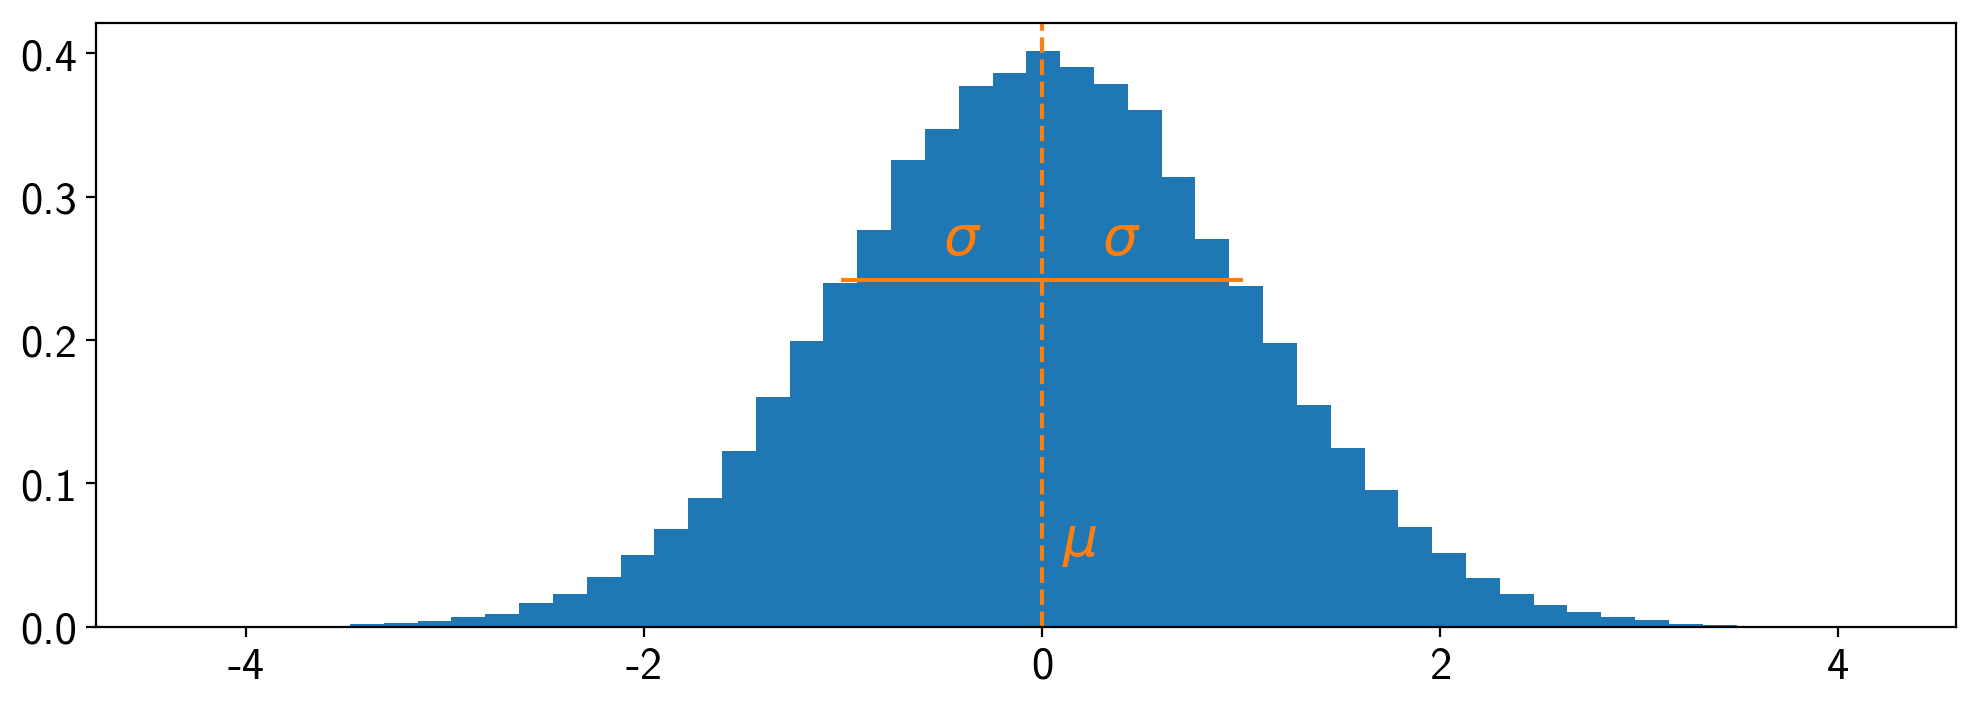

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
u = np.random.randn(100000)
plt.hist(u, bins=50, density=1);
plt.axvline(0, color="C1", ls="--")
y = np.exp(-0.5) / (np.sqrt(2 * np.pi))
plt.plot([-1, 1], [y, y], "C1-")
plt.text(0.1, 0.05, r"$\mu$", color="C1", fontsize=20);
plt.text(0.3, 0.26, r"$\sigma$", color="C1", fontsize=20);
plt.text(-0.5, 0.26, r"$\sigma$", color="C1", fontsize=20);

To draw from a Gaussian distribution with a different mean $\mu$, we simply *add* $\mu$ to $u$, and to draw from a distribution with different variance $\sigma^2$, we simply *multiply* $u$ by $\sigma$. We can therefore draw from a Gaussian with mean (say) $10.0$ and variance $5.0^2$ by running

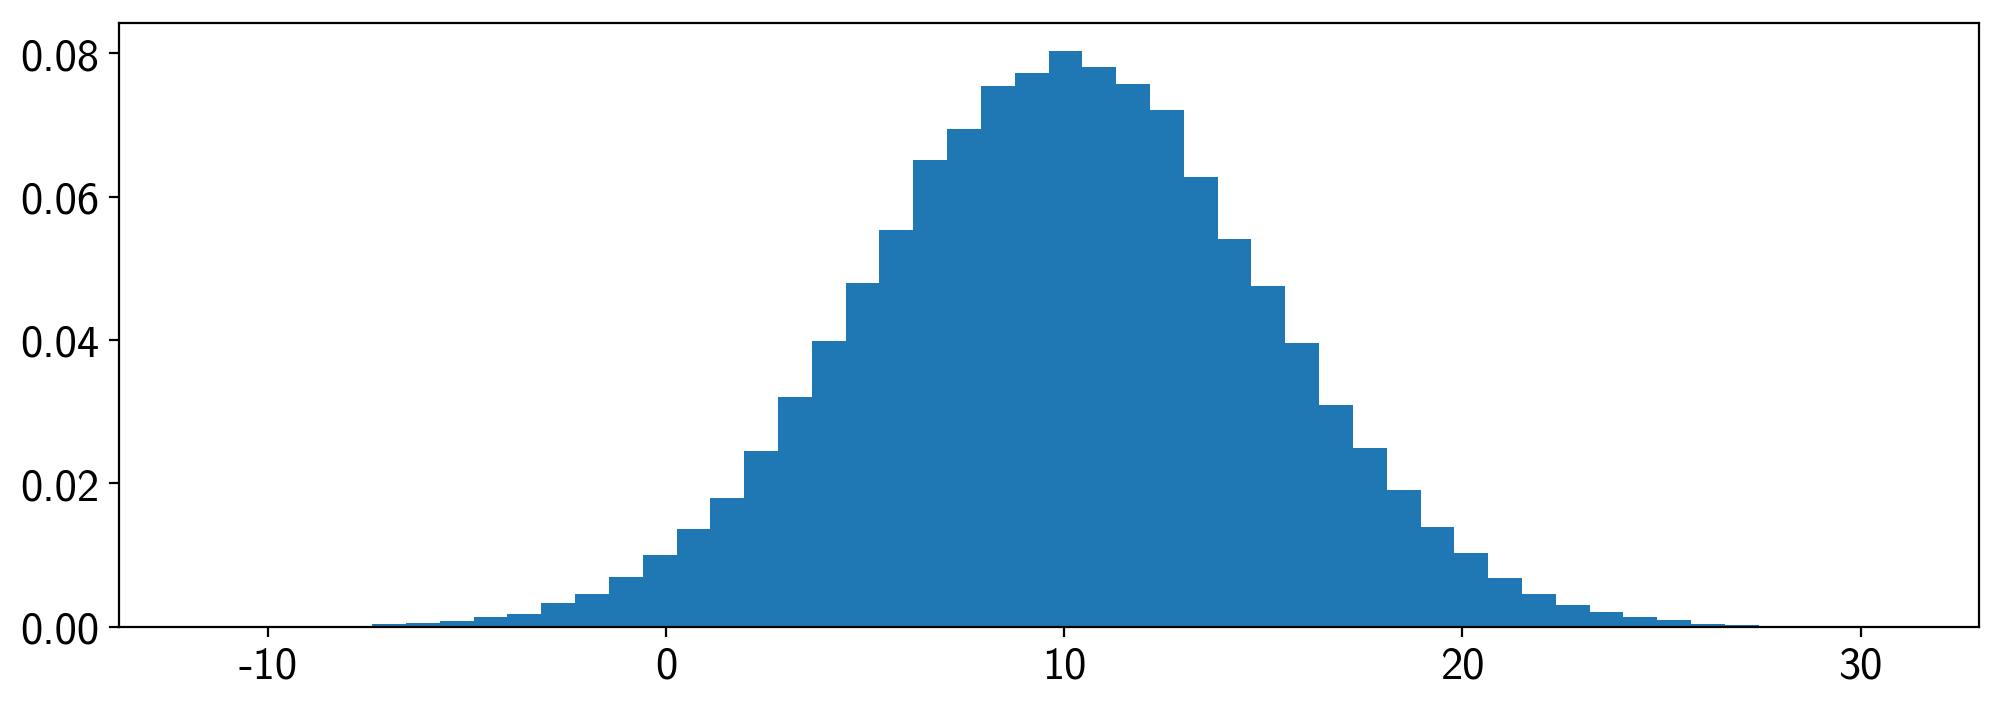

In [6]:
np.random.seed(1)
u = np.random.randn(100000)
plt.hist(10.0 + 5.0 * u, bins=50, density=1);

**Easy.** But what about Gaussians in multiple dimensions, where there can be correlations (covariances) between the various dimensions? Say we want to draw from the normal distribution $\mathcal{N}(0, \mathbf{\Sigma})$, where $\mathbf{\Sigma}$ is the *covariance matrix*:

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 \mathrm{Var(x_0)} & \mathrm{Cov(x_0, x_1)} & \cdots & \mathrm{Cov(x_0, x_N)} \\ \\
 \mathrm{Cov(x_1, x_0)} & \mathrm{Var(x_1)} & \cdots & \mathrm{Cov(x_1, x_N)} \\ \\
 \vdots & \vdots & \ddots & \vdots \\ \\
 \mathrm{Cov(x_N, x_0)} & \mathrm{Cov(x_N, x_1)} & \cdots & \mathrm{Var(x_N)}
\end{pmatrix}
$$

Here, $\mathrm{Var(x_i)}$ is the variance, or square of the standard deviation, along the $i^\mathrm{th}$ dimension, and $\mathrm{Cov(x_i, x_j)}$ is the covariance $-$ a measure of how two variables vary jointly $-$ between the $i^\mathrm{th}$ and $j^\mathrm{th}$ dimensions.

It's hard to picture a multivariate Gaussian, but it helps to imagine what the contours of equal probability (or equipotential surfaces) look like. For a two dimensional standard normal with no covariance ($\mathbf{\Sigma} = \mathbf{I}$), these are just circles. As I add to the off-diagonal terms of the matrix, I introduce a preferred direction in the space, since now the dimensions are correlated. The circle becomes an ellipse whose elongation increases with the covariance. In the general case of a multidimensional Gaussian, the contours form a multidimensional ellipsoid, elongated by different amounts along different dimensions.

**So.** How do we draw samples from a multivariate Gaussian given $\mathbf{\Sigma}$? It turns out there's a simple trick. Take $u$ to be a variable drawn from the standard normal (as we did above with ``u = np.random.randn()``) in $N$ dimensions. If we transform $u$ by a yet-to-be-determined operator (matrix) $\mathbf{L}$,

$$
\begin{align}
x = \mathbf{L}u
\end{align}
$$

we now have a random variable $x$ whose variance is

$$
\begin{align}
\mathrm{Var}(x) &\equiv \left< x x^\top \right> \\
                &= \left< \left(\mathbf{L}u\right) \left(\mathbf{L}u \right)^\top \right> \\
                &= \left< \mathbf{L} uu^\top \mathbf{L}^\top \right> \\
                &= \mathbf{L} \left<uu^\top\right> \mathbf{L}^\top \\
                &= \mathbf{L} \mathrm{Var}(u) \mathbf{L}^\top \\
                &= \mathbf{L}\mathbf{L}^\top.
\end{align}
$$

In the expressions above, I used the fact that the variance of a random variable is defined as the expectation value (denoted by $\left<\,\right>$) of the squared deviation from the mean (zero, in this case). The expectation value of $\mathbf{L}$ is just $\mathbf{L}$ (since it is constant), and the variance of $u$ is unity (by construction).

Now, all we have to do is find a matrix $\mathbf{L}$ such that

$$
\begin{align}
\mathbf{\Sigma} &= \mathbf{L} \mathbf{L}^\top
\end{align}
$$

and we're done!

**But how do we do that?** As it happens, what we're trying to do has a name: it's the **Cholesky decomposition** of $\mathbf{\Sigma}$. Formally, all the Cholesky decomposition does is to find a factorization of a matrix $\mathbf{\Sigma}$ in the form given by the expression above, where $\mathbf{L}$ is a lower triangular matrix. You can (informally) think of this decomposition as finding the square root of $\mathbf{\Sigma}$, and it is *enormously* useful for GPs (and linear algebra in general). Note that the Cholesky decomposition only works for Hermitian (symmetric), positive-definite matrices, but those are the only kinds of matrices we'll be dealing with here anyways.

To perform the Cholesky decomposition in Python, use ``scipy``:

```python
from scipy.linalg import cho_factor
L, _ = cho_factor(S, lower=True)  # Compute the lower triangular matrix L
L = np.tril(L)                    # Ensure the upper triangle of L is zeroed out
```

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1a</h1>
</div>

Define a function ``draw_from_gaussian(mu, S, ndraws=1)`` that returns ``ndraws`` samples from a multivariate Gaussian with mean ``mu`` and covariance matrix ``S``. The shape of the output should be ``(ndraws, ndim)`` where ``ndim`` is the dimension of the Gaussian. Note that as ``S`` gets large, roundoff error can often accumulate in the Cholesky decomposition, potentially causing weird ``LinearAlgebraError``s. For this reason, it's good practice to always add a tiny number to the diagonal of a matrix (something like ``1e-12``) whenever decomposing it, factorizing it, inverting it, etc. You probably want to bake that into your code to compute ``L``.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1b</h1>
</div>

Draw ``10,000`` samples from a zero-mean Gaussian with covariance

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 1 & 0.5 \\
 0.5 & 1
\end{pmatrix}
$$

Plot the "corner" plot for your ``samples`` using the ``corner`` package (``!pip install corner``):

```python
from corner import corner
fig = corner(samples);
```

Vary the terms in the covariance matrix (recalling that it must be symmetric!) to get a sense of how they affect the joint distribution of samples.

## Parametrizing the covariance

As the number of dimensions increases, and in particular as it becomes *infinite* (which it will, when we get to actual Gaussian Processes), it's no longer convenient to describe the covariance in terms of every single entry in the covariance matrix. Instead, it's useful to introduce the notion of a *kernel*, a function of just a few parameters that describes the overall structure of the covariance matrix.

In general, the covariance matrix can have *any* structure, but quite often in timeseries analysis *data points close to each other in time are strongly correlated*. This is true whether your timeseries contains photometric variability from a rotating star, the rise and fall of a supernova light curve, a gravitational wave signal, or PSF shape changes due to temperature fluctuations on the detector. This is because each of these processes have characteristic timescales over which they operate, and on timescales shorter than that, all measurements you make are likely to be close to relatively each other. But if you wait long enough, what your system will do down the line will be pretty decoupled from what it is doing right now.

So we can imagine defining a kernel that looks something like this: 

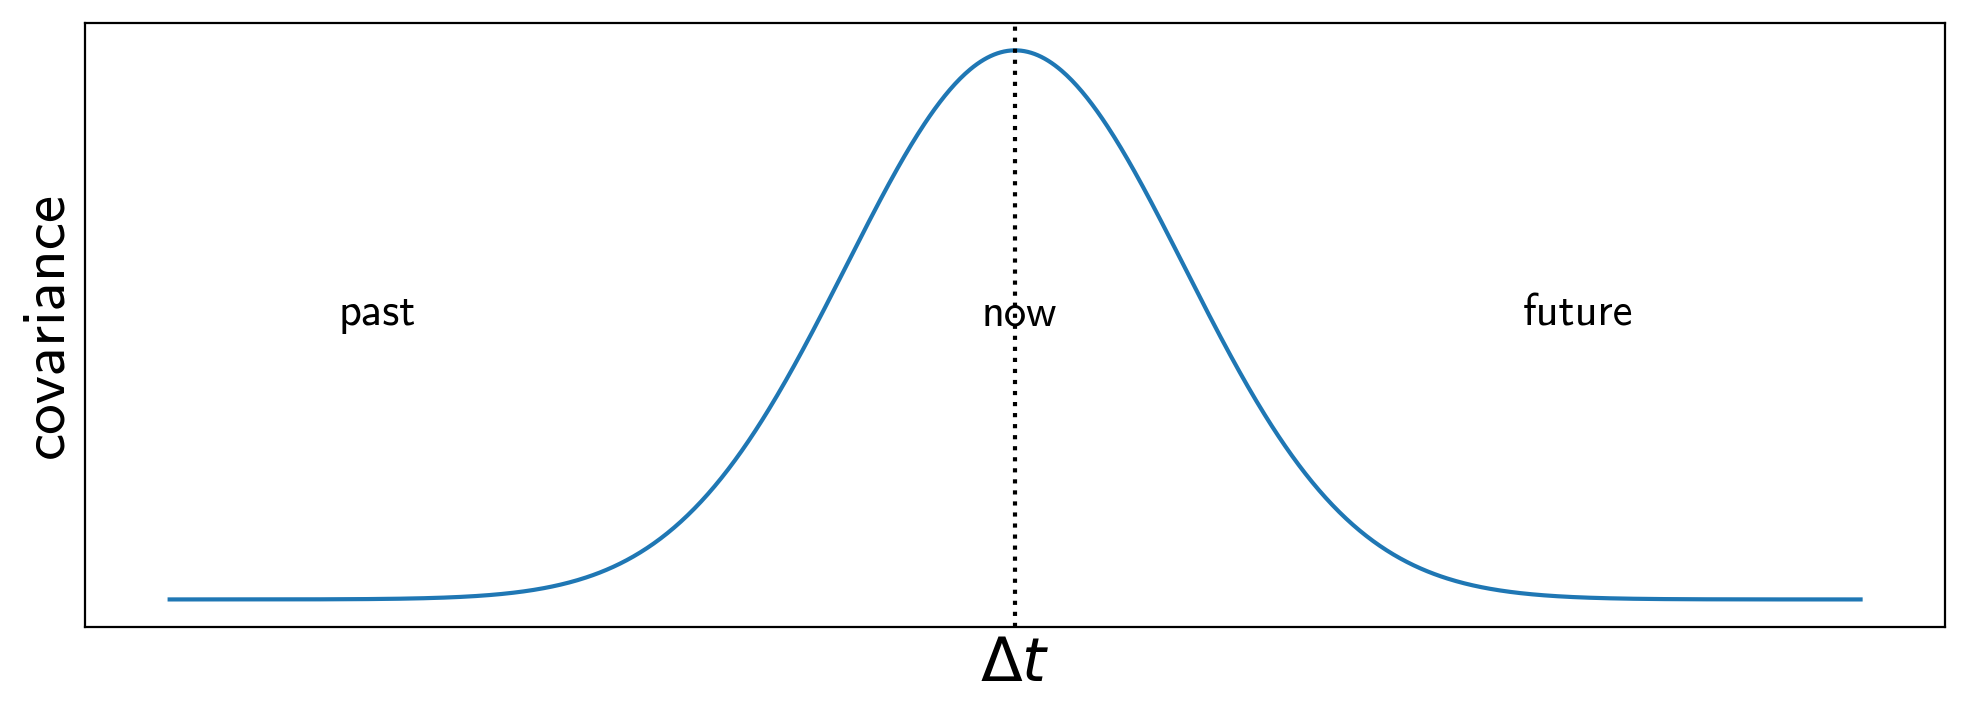

In [9]:
%show_kernel

where the covariance peaks at zero time lag and drops smoothly to zero as the time lag increases. This particular kernel is extremely useful and has a name: the *Squared Exponential Kernel*, defined as

$$
\begin{align}
    k(t_i, t_j) = A^2 \exp\left(-\frac{\left(t_i - t_j\right)^2}{2l^2}\right)
\end{align}
$$

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2a</h1>
</div>

Define a function ``ExpSquaredKernel(t, A=1.0, l=1.0)`` that returns the covariance matrix described by the squared exponential kernel for a timeseries ``t``.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2c</h1>
</div>

For ``t = np.linspace(0, 2, 11)``, draw ``10,000`` samples from the guassian described by the covariance matrix and plot the corresponding corner plot, labeling each subplot with the time point it represents. Comment on the structure of the plot and the correlations among the different dimensions.

## From Gaussians to Gaussian Processes

So far we've been taking about Gaussians *distributions* and how they can jointly model a few random variables at a time. But what happens as the dimensionality of the Gaussian increases and eventually becomes infinite? The Gaussian no longer represents a collection of random variables, but instead the behaviour of a continuous function. And that's exactly what a Gaussian Process is: a distribution over functions with infinitely many points. We can't technically model a function with infinitely many points on a computer, but we can investigate what happens as the number of points becomes very large.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3a</h1>
</div>

Construct a ``1000 x 1000`` covariance matrix using the squared exponential kernel for a timeseries spanning 10 time units, and plot an image of it using ``plt.imshow``. Comment on the structure of the matrix.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3b</h1>
</div>

Draw ``30`` samples from the zero-mean Gaussian described by the covariance matrix above. Each sample should be a vector of length ``1,000``. Plot each sample against time on the same plot. Also plot the mean function and use ``plt.fill_between`` to shade the 1- and 2-$\sigma$ levels of the Gaussian Process. Recall that the variance $\sigma^2$ at each point in time is given by the corresponding entry on the diagonal of $\mathbf{\Sigma}$.

Next, vary the hyperparameters of the GP, $A$ and $l$, and comment on how they change the behavior of the GP.

## Conditioning on data

If you completed **Exercise 3b**, you have actually implemented your own Gaussian Process! But it's still pretty simple, because so far we are drawing only from our *prior*: we know the Gaussian has a certain covariance and a certain mean (zero, in the case above), but nothing else about how it's supposed to behave. To apply this to a real dataset, we need to *condition* the GP on observations.

Say I make two perfectly noise-free observations:

$$
\begin{align}
    y(t = 2.5) &= 1.0 \\
    y(t = 7.5) &= -1.0
\end{align}
$$

Again, $y$ could be anything: the flux received from a star, the strain due to a gravitational wave, etc. I want to draw new samples from my GP, but not just *any* samples: I explicitly want to draw functions that go through those two data points. One (very inefficient) way to do this is to draw a *ton* of samples and discard any samples that don't agree with the data. (In this particular case, that would be literally impossible, since I know $y(t)$ at those two points *exactly*: I will never draw at random a function whose value is exactly what I want it to be. But note that *rejection sampling* can actually be useful in other cases. Anyways.)

A *better* way to do this is to consider the *joint distribution* of the observed data $y(t)$ (usually called the "training set") and the points where I'm trying to predict the value of the function $y_\star(t_\star)$ (the "test set"):

$$
\begin{align}
\begin{pmatrix}
 y \\
 y_\star
\end{pmatrix}
&=
\mathcal{N}
\left[
\mathbf{0},
\begin{pmatrix}
 \mathbf{\Sigma}(t, t) & \mathbf{\Sigma}(t, t_\star)\\
 \mathbf{\Sigma}(t_\star, t) & \mathbf{\Sigma}(t_\star, t_\star)
\end{pmatrix}
\right]
\end{align}
$$

where $\mathbf{\Sigma}(t, t)$ is the $N_\mathrm{train} \times N_\mathrm{train}$ covariance matrix evaluated at all pairs of training points, $\mathbf{\Sigma}(t_\star, t_\star)$ is the $N_\mathrm{test} \times N_\mathrm{test}$ covariance matrix evaluated at all pairs of test points, and the remaining two entries are the (rectangular) covariance matrices evaluated at all pairs of (test, training) points.

Given this joint distribution, we can compute the *conditional* distribution of $y_\star$ given $y$ with some linear algebra (for a derivation, see Appendix A.2 of [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) and references therein):

$$
\begin{align}
y_\star | y \sim \mathcal{N}\left( 
    \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1}y,
    \mathbf{\Sigma}(t_\star, t_\star) - 
        \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1} \mathbf{\Sigma}(t, t_\star)
\right)
\end{align}
$$

In other words, given $y$, the distribution for $y_\star$ is *still Gaussian*, but this time with mean equal to
$$
\begin{align}
    \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1}y
\end{align}
$$
and covariance
$$
\begin{align}
    \mathbf{\Sigma}(t_\star, t_\star) - \mathbf{\Sigma}(t_\star, t) \mathbf{\Sigma}(t, t)^{-1} \mathbf{\Sigma}(t, t_\star)
\end{align}
$$

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 4</h1>
</div>

Show that when $t_\star = t$, the mean and covariance of the GP for $y_\star$ give you what you'd expect. When $t_\star \neq t$, what can you say about the variance of the GP after versus before data was collected?

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 5a</h1>
</div>

Define a function ``compute_gp(t_train, y_train, t_test, **kwargs)`` that returns the mean and covariance of the Gaussian process for ``y_test(t_test)`` conditioned on ``y_train(t_train)``. The ``**kwargs`` are for additional optional keyword arguments passed directly to the kernel (in this simple case, ``A`` and ``l``). You will need to re-define the ``ExpSquaredKernel`` to take *two* timeseries as inputs so you can compute the covariance between $t$ and $t_\star$.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 5b</h1>
</div>

Given

```python
t_train = np.array([2.5, 7.5])
y_train = np.array([1.0, -1.0])
t_test = np.linspace(0, 10, 1000)
```

compute the mean and covariance of the GP. Draw ``30`` samples from it as before. Plot the mean function and shade the 1- and 2-$\sigma$ levels. Comment on the behavior of the GP. Does the GP correctly predict the training points? How does the variance behave close to and far from the training points? How does the GP behave very far from the training points?

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 6</h1>
</div>

The last thing we'll do regarding drawing from a GP is to account for noise in the observations. If the measurement error on the data points is Gaussian and uncorrelated (white), as we usually assume it to be, we simply add a term to the joint distribution of the training and test data:

$$
\begin{align}
\begin{pmatrix}
 y \\
 y_\star
\end{pmatrix}
&=
\mathcal{N}
\left[
\mathbf{0},
\begin{pmatrix}
 \mathbf{\Sigma}(t, t) + \sigma_n^2 \mathbf{I} & \mathbf{\Sigma}(t, t_\star)\\
 \mathbf{\Sigma}(t_\star, t) & \mathbf{\Sigma}(t_\star, t_\star)
\end{pmatrix}
\right]
\end{align}
$$

where $\sigma_n$ is the standard deviation for the $n^\mathrm{th}$ data point in the training set and $\mathbf{I}$ is the identiy matrix. Figure out how this changes the expression for the mean and variance of the GP and re-plot the figure from **Exercise 5b**, this time given an observational uncertainty $\sigma = 0.25$ at both training points. Comment on the new behavior of the GP.